In [83]:
import torch 
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../Data/NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

# Feature eng...

In [5]:
def haversine_distance(df,lat1, long1, lat2, long2):


    '''
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    '''
    r = 6371 #average radius of Earth in kilometers
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers
    
    return d


In [6]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Add a datetime column and derive useful statistics

In [7]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S' ,infer_datetime_format=True)

In [8]:
df['EDTdate'] = df['EDTdate'].dt.tz_convert('US/Eastern')
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56-04:00,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53-04:00,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26-04:00,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03-04:00,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01-04:00,22,pm,Fri


# Disinguishing cat(Nominal) and continous var

we will use  pytorch embeddings to do one hot encoding. Incase you are thinking of why not one hot

In [10]:
cat_cols = ['Hour','AMorPM','Weekday']
cont_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','dist_km']

In [11]:
y_col = ['fare_amount']

In [12]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [13]:
df.dtypes

pickup_datetime                          object
fare_amount                             float64
fare_class                                int64
pickup_longitude                        float64
pickup_latitude                         float64
dropoff_longitude                       float64
dropoff_latitude                        float64
passenger_count                           int64
dist_km                                 float64
EDTdate              datetime64[ns, US/Eastern]
Hour                                   category
AMorPM                                 category
Weekday                                category
dtype: object

In [14]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [15]:
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [16]:
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [17]:
df['Weekday'].cat.codes

0         1
1         2
2         2
3         3
4         0
         ..
119995    3
119996    0
119997    3
119998    5
119999    2
Length: 120000, dtype: int8

In [18]:
#numpy array
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [20]:
cats = np.stack([hr,ampm,wkdy],axis=1)

In [21]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [22]:
#one line for what we did is
cats = np.stack([df[col].cat.codes.values for col in cat_cols],1)

In [23]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [24]:
cats = torch.tensor(cats, dtype=torch.int64)

In [25]:
conts = np.stack([df[cols].values for cols in cont_cols],axis=1)

In [26]:
conts = torch.tensor(conts, dtype=torch.float)

In [27]:
y = torch.tensor(df[y_col].values,dtype=torch.float)#make sure shape i s(m,1) i.e column vector

In [28]:
cats.shape

torch.Size([120000, 3])

In [107]:
conts.shape

torch.Size([120000, 6])

In [30]:
y.shape

torch.Size([120000, 1])

### Using embedding layers

* Here we do one hot encodings

In [31]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

In [32]:
list(zip(cat_cols,cat_sizes))

[('Hour', 24), ('AMorPM', 2), ('Weekday', 7)]

In [33]:
emb_szs = [(size,min(50,size+1)//2) for size in cat_sizes]

In [34]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

# Full model

How embeddings work.
*  walkthrough on first 5 rows

In [35]:
cat_dummy = cats[:5]

In [36]:
cat_dummy

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [37]:
list(zip(cat_cols,cat_sizes))

[('Hour', 24), ('AMorPM', 2), ('Weekday', 7)]

In [38]:
[nn.Embedding(ni,nf) for ni,nf in emb_szs]

[Embedding(24, 12), Embedding(2, 1), Embedding(7, 4)]

In [39]:
#part of forward method
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])

In [61]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [41]:
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(cat_dummy[:,i]))

In [42]:
embeddingz

[tensor([[-0.0099,  2.1081, -0.3449,  0.0157, -0.6134, -0.4468, -0.2081, -0.9935,
          -1.4102,  1.2612, -0.5315,  1.0272],
         [ 0.1864, -0.3286, -1.5142,  0.9716, -2.0130,  1.6936,  0.2642,  0.0587,
          -1.8423,  0.9034,  0.5953, -0.2455],
         [ 0.2100,  0.4958,  0.4505, -0.8544, -1.1846,  1.2074, -0.7880,  1.2714,
           0.9608,  0.1988, -1.1451, -0.1656],
         [-1.1580,  0.4702,  0.0442, -0.5217, -1.0773, -0.8127,  0.0878,  1.2420,
           0.5959, -0.8787, -0.9985,  0.8298],
         [-1.6144, -2.0590, -0.5502,  0.4280, -0.1891, -0.6677, -0.7733,  0.2619,
          -0.2798, -0.4935, -0.7826,  0.6454]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.4802],
         [ 0.4802],
         [ 0.4802],
         [-1.4262],
         [-1.4262]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.4957, -0.1553,  0.1343, -0.9019],
         [-0.6002,  1.2744, -0.6830,  0.6717],
         [-0.6002,  1.2744, -0.6830,  0.6717],
         [ 1.5997, -0.4464,  0.2442,  1.0775],
   

In [43]:
cat_dummy

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [82]:
print(embeddingz[0].shape)
print(selfembeds[0].weight.data.shape)

torch.Size([5, 12])
torch.Size([24, 12])


In [79]:
embeddingz[0]

tensor([[-0.0099,  2.1081, -0.3449,  0.0157, -0.6134, -0.4468, -0.2081, -0.9935,
         -1.4102,  1.2612, -0.5315,  1.0272],
        [ 0.1864, -0.3286, -1.5142,  0.9716, -2.0130,  1.6936,  0.2642,  0.0587,
         -1.8423,  0.9034,  0.5953, -0.2455],
        [ 0.2100,  0.4958,  0.4505, -0.8544, -1.1846,  1.2074, -0.7880,  1.2714,
          0.9608,  0.1988, -1.1451, -0.1656],
        [-1.1580,  0.4702,  0.0442, -0.5217, -1.0773, -0.8127,  0.0878,  1.2420,
          0.5959, -0.8787, -0.9985,  0.8298],
        [-1.6144, -2.0590, -0.5502,  0.4280, -0.1891, -0.6677, -0.7733,  0.2619,
         -0.2798, -0.4935, -0.7826,  0.6454]], grad_fn=<EmbeddingBackward0>)

In [69]:
selfembeds[0].weight.data

tensor([[-0.8842,  0.4095, -1.7777, -0.5547,  0.7673,  0.4970,  0.7815, -1.6710,
         -0.8847, -1.0718, -1.2784, -0.6365],
        [ 0.2373,  2.0062, -0.4167, -0.0481, -1.4746,  0.5792,  0.5248,  0.9623,
         -0.1098, -0.3934,  0.5705, -0.4521],
        [-0.5061, -0.9158,  0.4540,  1.0269,  0.0541, -0.4134,  0.4338,  1.4991,
          0.6874,  0.6366, -0.9080, -0.0151],
        [ 1.0025,  0.4042,  1.3261, -0.8884,  1.7193,  1.0874, -0.0287, -2.3839,
          0.7434,  0.8782,  1.6157,  0.0130],
        [-0.0099,  2.1081, -0.3449,  0.0157, -0.6134, -0.4468, -0.2081, -0.9935,
         -1.4102,  1.2612, -0.5315,  1.0272],
        [-0.2610,  0.7103, -0.1165, -0.9161,  0.1401,  0.1498, -0.3128,  1.0863,
         -0.9149, -0.5330,  0.5284, -0.2634],
        [ 1.3674, -0.0281,  0.9046,  0.8881,  1.2738,  0.7387, -1.5877, -0.3243,
          0.1516,  0.8448,  0.4885,  1.5968],
        [ 0.2100,  0.4958,  0.4505, -0.8544, -1.1846,  1.2074, -0.7880,  1.2714,
          0.9608,  0.1988, -1.

In [84]:
#finally pass it to a dropout layer
#we have defined 
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [86]:
#and we passed it through
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(cat_dummy[:,i]))

In [87]:
embeddingz

[tensor([[-0.0099,  2.1081, -0.3449,  0.0157, -0.6134, -0.4468, -0.2081, -0.9935,
          -1.4102,  1.2612, -0.5315,  1.0272],
         [ 0.1864, -0.3286, -1.5142,  0.9716, -2.0130,  1.6936,  0.2642,  0.0587,
          -1.8423,  0.9034,  0.5953, -0.2455],
         [ 0.2100,  0.4958,  0.4505, -0.8544, -1.1846,  1.2074, -0.7880,  1.2714,
           0.9608,  0.1988, -1.1451, -0.1656],
         [-1.1580,  0.4702,  0.0442, -0.5217, -1.0773, -0.8127,  0.0878,  1.2420,
           0.5959, -0.8787, -0.9985,  0.8298],
         [-1.6144, -2.0590, -0.5502,  0.4280, -0.1891, -0.6677, -0.7733,  0.2619,
          -0.2798, -0.4935, -0.7826,  0.6454]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.4802],
         [ 0.4802],
         [ 0.4802],
         [-1.4262],
         [-1.4262]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.4957, -0.1553,  0.1343, -0.9019],
         [-0.6002,  1.2744, -0.6830,  0.6717],
         [-0.6002,  1.2744, -0.6830,  0.6717],
         [ 1.5997, -0.4464,  0.2442,  1.0775],
   

In [97]:
print(embeddingz[0].shape)
print(embeddingz[1].shape)
print(embeddingz[2].shape)

torch.Size([5, 12])
torch.Size([5, 1])
torch.Size([5, 4])


In [99]:
z = torch.cat(embeddingz,1)#making them in one tensor

In [94]:
z.shape

torch.Size([5, 17])

In [100]:
drop_out = nn.Dropout(0.4)

In [101]:
drop_out(z)

tensor([[-0.0000,  3.5135, -0.5749,  0.0000, -1.0223, -0.7447, -0.3469, -1.6558,
         -2.3503,  0.0000, -0.8859,  1.7120,  0.0000,  2.4928, -0.0000,  0.0000,
         -1.5032],
        [ 0.0000, -0.0000, -2.5236,  0.0000, -3.3550,  2.8227,  0.0000,  0.0000,
         -3.0705,  0.0000,  0.9922, -0.4091,  0.8003, -1.0003,  0.0000, -0.0000,
          0.0000],
        [ 0.0000,  0.0000,  0.0000, -1.4240, -0.0000,  2.0123, -1.3133,  2.1191,
          0.0000,  0.0000, -0.0000, -0.0000,  0.8003, -1.0003,  2.1240, -0.0000,
          1.1194],
        [-1.9300,  0.7837,  0.0737, -0.8695, -1.7955, -1.3545,  0.1463,  2.0701,
          0.9932, -1.4645, -0.0000,  1.3830, -2.3771,  2.6662, -0.0000,  0.4071,
          0.0000],
        [-0.0000, -3.4317, -0.0000,  0.7134, -0.3151, -1.1128, -1.2888,  0.4364,
         -0.4664, -0.8226, -0.0000,  0.0000, -0.0000, -0.2732,  0.0000, -0.2252,
         -0.0000]], grad_fn=<MulBackward0>)

In [178]:
class TabularModel(nn.Module):
    def __init__(self,emb_szs, n_cont, out_sz, layers, p=0.5):
        
        '''
        layers is the list passed by user 
            layers = [100,200,3] 
            this signifies number of neurons in each layer
        100 in 1st layer, then 200
        '''
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        
        n_emb = sum([nf for ni,nf in emb_szs])
        
        n_in = n_emb+ n_cont
        
        #for loopmakes it flexible
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        full_data = torch.cat([x, x_cont],1)#combinig them
        
        full_data = self.layers(full_data)
        
        return full_data

In [179]:
torch.manual_seed(33)

In [180]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [181]:
model = TabularModel(emb_szs,conts.shape[1],1,[200,100],p=0.4)

In [182]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [183]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [184]:
batch_size = 60000

test_size = int(batch_size *0.2)


In [185]:
#DATA Shuffled

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]

con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [186]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [187]:
len(cat_train), len(y_train)

(48000, 48000)

In [188]:
from time import perf_counter

In [189]:
t0 = perf_counter()

epochs = 300

losses= []

for i in range(epochs):
    i +=1
    
    y_pred = model(cat_train,con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss.detach().numpy())
    
    if i%10==1:
        print(f'epoch: {i} loss is {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = perf_counter() - t0

epoch: 1 loss is 12.586843490600586
epoch: 11 loss is 11.687362670898438
epoch: 21 loss is 11.121127128601074
epoch: 31 loss is 10.733322143554688
epoch: 41 loss is 10.460418701171875
epoch: 51 loss is 10.234882354736328
epoch: 61 loss is 10.028034210205078
epoch: 71 loss is 9.849187850952148
epoch: 81 loss is 9.635196685791016
epoch: 91 loss is 9.413382530212402
epoch: 101 loss is 9.17296314239502
epoch: 111 loss is 8.894386291503906
epoch: 121 loss is 8.578813552856445
epoch: 131 loss is 8.216830253601074
epoch: 141 loss is 7.808000087738037
epoch: 151 loss is 7.364787578582764
epoch: 161 loss is 6.919034957885742
epoch: 171 loss is 6.456644058227539
epoch: 181 loss is 5.9670796394348145
epoch: 191 loss is 5.461026191711426
epoch: 201 loss is 5.017233848571777
epoch: 211 loss is 4.630398273468018
epoch: 221 loss is 4.340794563293457
epoch: 231 loss is 4.098572254180908
epoch: 241 loss is 3.907663345336914
epoch: 251 loss is 3.8835651874542236
epoch: 261 loss is 3.797342538833618
epoc

In [193]:
duration/60 

2.0899686066666616

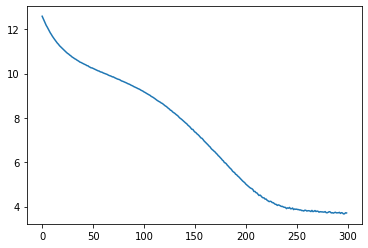

In [194]:
plt.plot(range(epochs),losses)

# validating

In [195]:
with torch.no_grad():
    
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))

In [196]:
loss

tensor(3.6358)

In [200]:
for i in range(10):
    print(f'{i}--prediction:{y_val[i].item():8.4f} TRUE {y_test[i].item():8.2f}')

0--prediction:  5.5017 TRUE     2.90
1--prediction: 13.4227 TRUE     5.70
2--prediction:  7.9796 TRUE     7.70
3--prediction: 14.4467 TRUE    12.50
4--prediction:  6.9225 TRUE     4.10
5--prediction:  6.0692 TRUE     5.30
6--prediction:  1.9292 TRUE     3.70
7--prediction: 18.7254 TRUE    14.50
8--prediction:  5.1816 TRUE     5.70
9--prediction: 13.8200 TRUE    10.10


## Saving a model

In [201]:
torch.save(model.state_dict(),'TaxiModel.pt')